# Node classification

The main steps of the node classification technique are:
1. Load the graph
2. Sample a number of random nodes (just to make the algorithm quicker)
3. Calculate and/or load the node embeddings
4. Split the graph into a train and test set
5. Train the ML classifier
6. Test the ML classifier

## About dataset

A large social network of GitHub developers which was collected from the public API in June 2019.

[git_nodes.csv](https://github.com/memgraph/graph-analytics-course/blob/master/lecture-5/node-classification/git_nodes.csv)
1. Nodes are developers who have starred at least 10 repositories.
2. Each developer is either a web developer **(0)** or a machine learning developer **(1)**

[git_edges.csv](https://github.com/memgraph/graph-analytics-course/blob/master/lecture-5/node-classification/git_edges.csv)
1. Edges are mutual follower relationships between them.

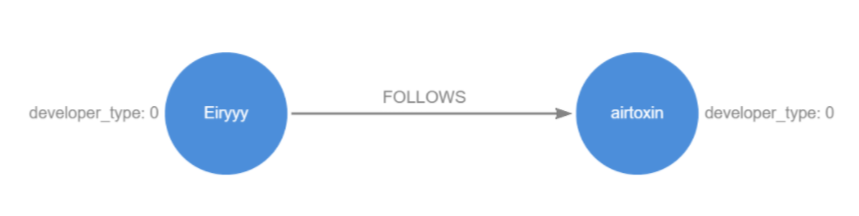

## Import necessary modules

In [1]:
import networkx as nx
import pandas as pd
import random
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from tqdm import tqdm

## Functions

### Load and sample graph
sampling method is used here just to make demonstration faster

In [2]:
# Create a NetworkX graph from files
def load_graph(edges_file_path, nodes_file_path):
    edges = pd.read_csv(edges_file_path, sep=',')
    nodes = pd.read_csv(nodes_file_path, sep=',')
    
    G = nx.from_pandas_edgelist(edges, 'id_1', 'id_2')
    
    # set developer type node attribute
    nx.set_node_attributes(G, pd.Series(
        nodes.developer_type, index=nodes.id).to_dict(), 'developer_type')
    # set id node attribute 
    nx.set_node_attributes(G, pd.Series(
        nodes.id, index=nodes.id).to_dict(), 'id')

    return G #return graph object 


# Select defined number of random nodes from a graph
# pass seed(random seed) to get predictable results 
def sample_graph(G, number_of_samples, seed):
    random.seed(seed)
    H = G.copy()
    samples = random.sample(list(G.nodes()), number_of_samples)
    for n in tqdm(G):
        if n not in samples: #remove nodes that ar not sampled 
            H.remove_node(n)

    H = StellarGraph.from_networkx(H) #generate StellarGraph from networkx
    return H

### Graph embeddings

In [3]:
# Load node embeddings from path
# format the trained the embeddings as dict - key/value
def load_embedding(file_path):
    embedding_dict = {}
    first_line = True
    with open(file_path) as f:
        for line in f:
            if first_line:
                first_line = False
                continue
            vector = [float(i) for i in line.strip().split()]
            embedding_dict[int(vector[0])] = vector[1:]
        f.close()
    return embedding_dict

# recalcuate / use curernt embeddings and save to path
def calculate_embeddings(recalculate_embeddings, G, embeddings_file_path):
    # to choose if recomputation is necessary
    if recalculate_embeddings == True:
        #perform random walk 
        rw = BiasedRandomWalk(G)
        walks = rw.run(nodes=list(G.nodes()), length=32, n=10, p=0.5, q=2.0)
        print("Number of random walks: {}".format(len(walks)))
        
        # convert to`list of list` format for inpurt arg `Word2Vec`
        # take str of each walks in the wallk
        str_walks = [[str(n) for n in walk] for walk in walks] 
        
        # train embedding model and compute embeddings
        model = Word2Vec(str_walks, vector_size=128, window=5, 
                         min_count=0, sg=1, workers=2, epochs =1)
        model.wv.save_word2vec_format(embeddings_file_path) 
    return load_embedding(embeddings_file_path)

### Apply machine lerarning - Classsification
embeddings are used as x data why the nodes are used as y data 

In [4]:
def split_data(G_nx, embeddings):
    X = []
    y = []
    for x in embeddings.keys():
        X.append(embeddings[x]) #embeddings value of the key
        y.append(G_nx.nodes[x]['developer_type']) #binary classifier 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test


def train_classifier(X_train, y_train):
    clf = LogisticRegressionCV(
        Cs=10, cv=10, scoring="accuracy", verbose=False, max_iter=3000
    )
    clf.fit(X_train, y_train)
    return clf


def test_classifier(X_test, y_test, clf):
    y_pred = clf.predict(X_test)
    print(f"Accuracy classification score: {accuracy_score(y_test, y_pred)}")

## `main` function - combination of all functions

In [10]:
# execute all defined functions with input parameters 
def main():
    G_nx = load_graph('git_edges.csv', 'git_nodes.csv') #return as networkx graph
    G = sample_graph(G_nx, 1000, 0) #return as stellarGraph
    embeddings = calculate_embeddings(False, G, 'embeddings.txt')
    X_train, X_test, y_train, y_test = split_data(G_nx, embeddings)
    clf = train_classifier(X_train, y_train)
    test_classifier(X_test, y_test, clf)

## Call `main`

In [11]:
# call main() only from this file 
# protect from accidentally invoking the script when they didn't intend to
if __name__ == "__main__":
    main()

100%|██████████████████████████████████████████████| 37700/37700 [00:02<00:00, 14838.94it/s]


Accuracy classification score: 0.775
